Group: 008-31

Members: Matthew Choi, Elizaveta Lazareva, Bianca Swartz, Vicky Yang

# Predicting Newsletter Subscription Using Player Demographics and Gameplay Behavior

## Introduction

### Background

In this project, we investigate a real dataset collected by a research group in the Computer Science department at UBC. The team operates a custom Minecraft research server where player activity is recorded. The goal of the project is to help the research group understand player behaviour, manage resources, and target recruitment efforts more effectively. 

The server collects data about each player's demographic information as well as their in-game behaviour. Understanding how players interact with the server has practical importance. It affects decisions such as when to allocate server resources, what types of players are most valuable to recruit, and what characteristics are associated with certain behaviors such as subscribing to project newsletters.

### Question

In this report, we address the following specific question:

**Can a player's age, gender, experience level, total playtime, number of sessions, and average session duration be used to predict whether they subscribe to the newsletter?**

The aim of the question is to determine which features of a player (such as age, gender, experience, number of sessions, total playtime, and other behavioural summaries) are useful for predicting whether the player subscribed to the newsletter. Being able to predict this provides insight into which groups of players show more engagement with the project, which can help guide future outreach and recruitment strategies.

### Dataset Description

Two datasets are used in this project:

1. **players.csv**
    196 observations. Variables include:
    - Age (numeric)
    - gender (categorical)
    - experience (categorical)
    - played_hours (numeric)
    - subscribe (True or False)
    - hashedEmail (join key)
    - name (not used for analysis)|
2. **sessions.csv**  
    1535 observations. Variables include:
    - hashedEmail (foreign key)
    - original_start_time
    - original_end_time
    - start_time, end_time

### Plan for Data Usage
1. Compute session summaries: total sessions and average duration.
2. Join summaries with players.csv.
3. Use cleaned variables as predictors for kNN classification.

These processed variables will be used as predictors in a classification model that attempts to predict newsletter subscription.



## Method & Results

### Method Description

### Wrangling Data

1. Join datasets: Combine players.csv and sessions.csv using hashedEmail (to find number if sessions).
2. Clean data: Remove or ignore missing values (for example, missing Age or end_time).
3. Feature creation: Compute the total number of sessions and the average session duration per player.
4. Convert data types: Make sure subscribe is a logical (TRUE/FALSE) variable and categorical predictors use factor().
5. Tidy data: Keep one row per player, with all relevant variables in columns.

In [2]:
library(tidyverse)
library(tidymodels)
set.seed(2024)
options(repr.plot.width = 10, repr.plot.height = 7)

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")
head(sessions)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [11]:
combined_data <- bind_rows(
  players |> select(hashedEmail, subscribe, Age, played_hours),
  sessions |> mutate(session_duration_min = (original_end_time - original_start_time) / (1000 * 60)) |>
           select(hashedEmail, session_duration_min)
) |>
  group_by(hashedEmail) |>
  summarize(
    subscribe = first(subscribe),
    Age = first(Age),
    played_hours = first(played_hours),
    n_sessions = sum(!is.na(session_duration_min)),
    mean_duration_min = mean(session_duration_min, na.rm = TRUE)
  ) |>
  mutate(subscribe = as_factor(subscribe)) |>
  select(subscribe, Age, played_hours, n_sessions, mean_duration_min) |>
filter(n_sessions > 0, mean_duration_min > 0)


head(combined_data)


subscribe,Age,played_hours,n_sessions,mean_duration_min
<fct>,<dbl>,<dbl>,<int>,<dbl>
TRUE,20,1.5,2,83.33333
TRUE,17,5.6,13,51.28205
TRUE,17,1.0,2,83.33333
TRUE,14,17.2,41,24.39024
TRUE,17,1.2,2,83.33333
TRUE,22,32.0,79,23.20675


In [18]:
mean_value <- players_tidy |>
summarize(mean_age = mean(Age, na.rm = TRUE), mean_played_hours = mean(played_hours, na.rm = TRUE)) |>
pivot_longer(cols = c(mean_age, mean_played_hours), names_to = "Variable", values_to = "Mean")

mean_value

Variable,Mean
<chr>,<dbl>
mean_age,21.139175
mean_played_hours,5.845918


### Visualization

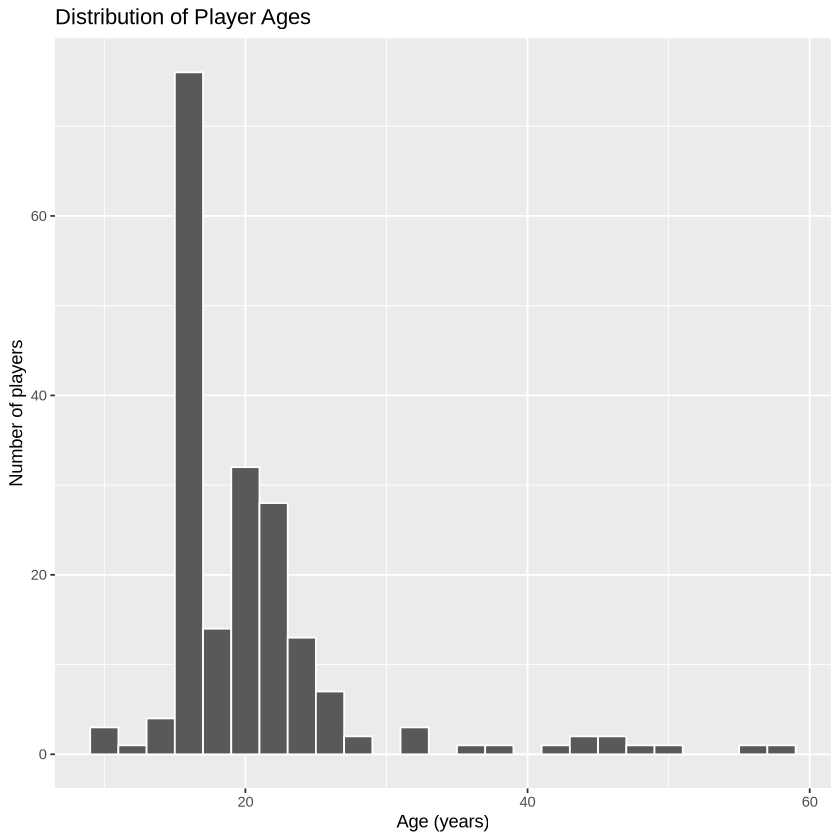

In [5]:
player_visualization <- players_tidy |> ggplot(aes(x = Age)) +
geom_histogram(binwidth = 2, color = "white", na.rm = TRUE) +
labs( title = "Distribution of Player Ages", x = "Age (years)", y = "Number of players")

player_visualization

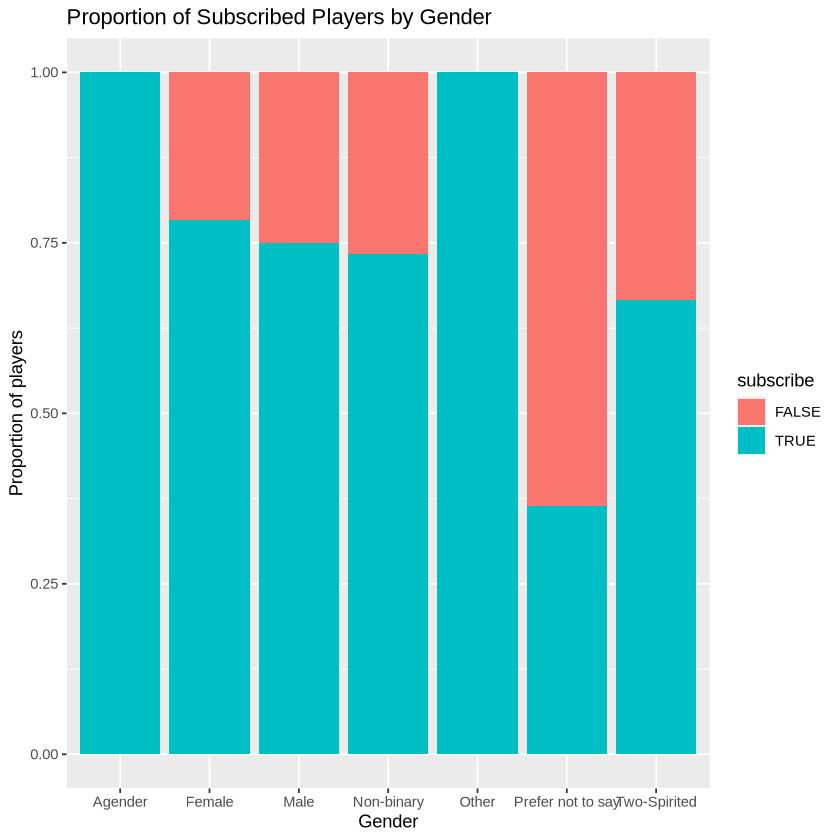

In [6]:
player_visualization2 <- ggplot(players_tidy, aes(x = gender, fill = subscribe)) +
geom_bar(position = "fill") +
labs(title = "Proportion of Subscribed Players by Gender", x = "Gender", y = "Proportion of players")

player_visualization2

In [1]:
players |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "dodge") +
  labs(title="Play Hours by Subscription", x="Hours Played", y="Count")


##I will change it later today

ERROR: Error in ggplot(players, aes(x = played_hours, fill = subscribe)): could not find function "ggplot"


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


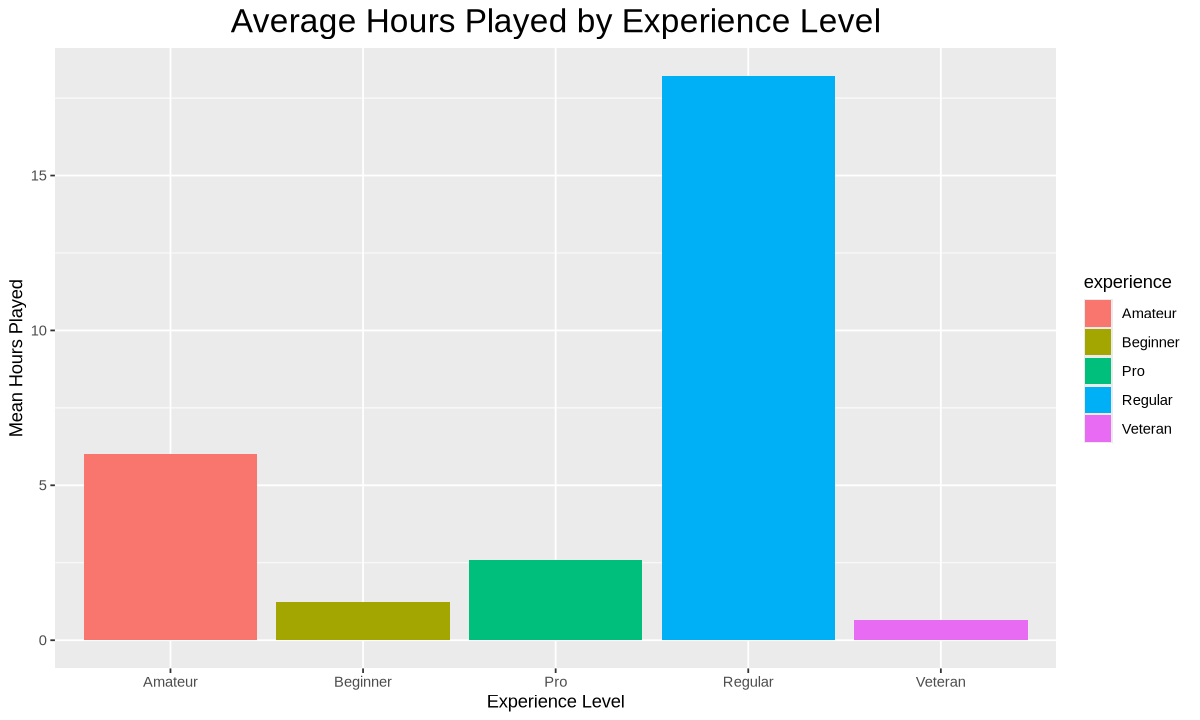

In [19]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

#relationship between experience level and average played hours
options(repr.plot.width = 10, repr.plot.height = 6)
experience_vs_played_hours_plot <- players |>
                                group_by(experience) |>
                                summarize(mean_hours = mean(played_hours, na.rm = TRUE)) |>
                                ggplot(aes(x = experience, y = mean_hours, fill = experience)) +
                                geom_col() +
                                labs(title = "Average Hours Played by Experience Level",
                                x = "Experience Level",
                                y = "Mean Hours Played") +
                                theme(plot.title = element_text(hjust = 0.5, size = 20))
experience_vs_played_hours_plot

Players with a regular experience level average the highest hours played, this is significant to the likelihood of newletter subscription if the average hours played is correlated to likelihood of subscription. 

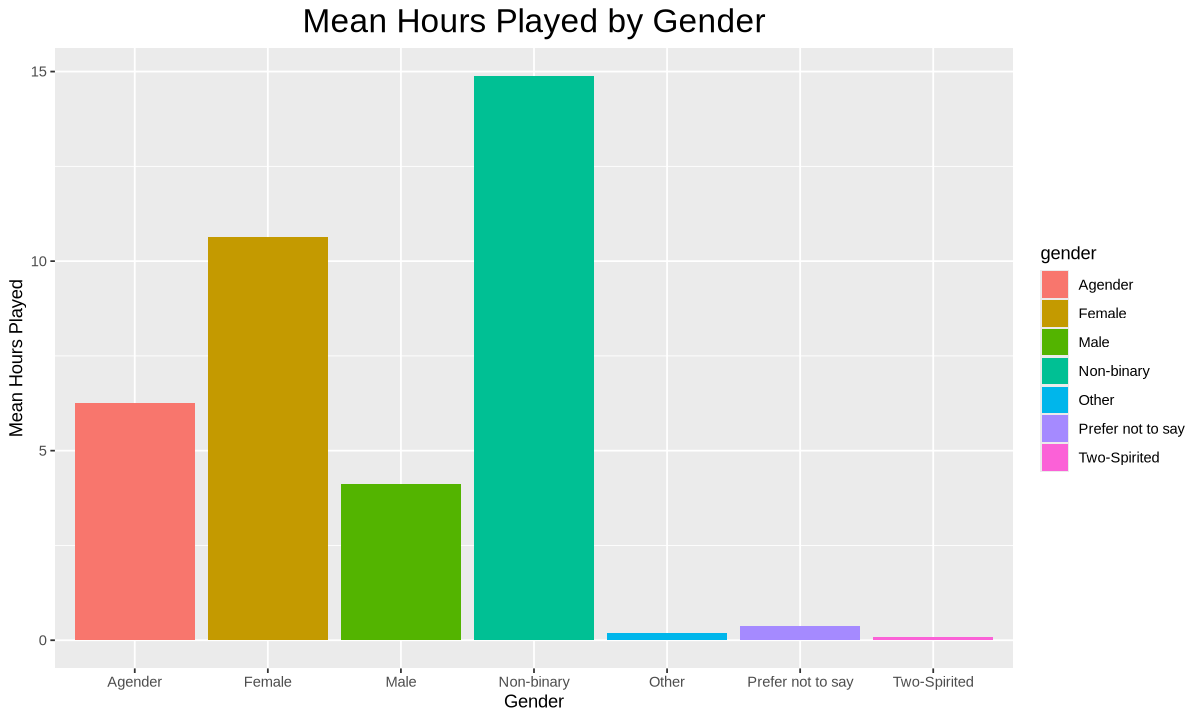

In [20]:
#relationship between gender and average played hours
options(repr.plot.width = 10, repr.plot.height = 6)
gender_vs_played_hours_plot <- players |>
                                group_by(gender) |>
                                summarize(mean_hours = mean(played_hours, na.rm = TRUE)) |>
                                ggplot(aes(x = gender, y = mean_hours, fill = gender)) +
                                geom_col() +
                                labs(title = "Mean Hours Played by Gender",
                                x = "Gender",
                                y = "Mean Hours Played") +
                                theme(plot.title = element_text(hjust = 0.5, size = 20))

gender_vs_played_hours_plot

Players identifying as non-binaryon average have the highest hours played, this is relevant to newsletter subscription if played hours is correlated with liklihood of subscription.